# US Churn &mdash; Feature Engineering


## Setup

In [5977]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "US_Churn"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

C:\Users\Kuba\AppData\Local\Temp\ipykernel_25616\208248166.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [5978]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")

## Imports

In [5979]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

## Datasets

In [5980]:
df = pd.read_pickle(f"{ROOT}/data/churn.pkl")
print(df.shape)
df.head()

(3333, 20)


,State,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,2,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [5981]:
# drop feature that I have not yet considered properly in EDA
for c in ["State"]:
    if c in df.columns: df.drop(c, axis='columns', inplace=True)

## Pre-process Data

In [5982]:
df_train, df_test = train_test_split(df, stratify=df.Churn, train_size=0.60, random_state=SEED)
df_train.shape, df_test.shape

((1999, 19), (1334, 19))

In [5983]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features

print(f"Target: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")
print(f"Number of Features: {len(features)}")

Target: Churn
Categorical Features: ['Area_Code', 'Intl_Plan', 'VMail_Plan']
Numerical Features: ['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']
Number of Features: 18


## Feature_Engineering 

Features engineering and selection decisions are carried out on `df_train` ONLY, but resulting operations should be applied to both `df_train` and `df_test`. The simplest way to do this (without repeating code) is to 

 * Perform querys on `df_train` to select new possible features.
 * Apply operations to `df` and repeat the train/test split USING THE SAME SEED.
 * You can use the target values in `df_train` but cannot use the target values in `df_test`.

### New Feature: Complainer
If a customer has above average amount of customer calls, they may be likely to churn

In [5984]:
df["Complainer"] = df.apply(lambda row: (row.CustServ_Calls > df.CustServ_Calls.median()), axis=1)

### New Feature: Loyal
A user with above average account length, may be more likely to stick with the company.

In [5985]:
df["Loyal"] = df.apply(lambda row: row.Account_Length > df.Account_Length.mean(), axis=1)

### New Feature: TotalCharges
A sum of all charges. A customer with higher charges may be more likely to churn

In [5986]:
df["TotalCharges"] = df.Night_Charge + df.Day_Charge + df.Eve_Charge + df.Intl_Charge
df.TotalCharges.describe()

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: TotalCharges, dtype: float64

### New Feature: BigSpender
A customer with above average total spending

In [5987]:
df["BigSpender"] = df.apply(lambda row: row.TotalCharges > df.TotalCharges.mean(), axis=1)

### New Feature: TotalCustomerCalls
A sum of all calls excluding customer service calls. A customer who doesn't call often may be likely to churn.

In [5988]:
df["TotalCustomerCalls"] = df.Night_Calls + df.Eve_Calls + df.Day_Calls + df.Intl_Calls
df.TotalCustomerCalls.describe()

count    3333.000000
mean      305.137114
std        34.448164
min       191.000000
25%       282.000000
50%       305.000000
75%       328.000000
max       416.000000
Name: TotalCustomerCalls, dtype: float64

### New Feature: TalkyTalker
A customer with above average TotalCustomerCalls

In [5989]:
df["TalkyTalker"] = df.apply(lambda row: row.TotalCustomerCalls > df.TotalCustomerCalls.mean(), axis=1)

### New Feature: TotalTimeOnCustomerCalls
A sum of minutes spent on calls excluding customer service calls. A customer who doesn't call for oftgen may be likely to churn.

In [5990]:
df["TotalTimeOnCustomerCalls"] = df.Day_Mins + df.Eve_Mins + df.Night_Mins + df.Intl_Mins
df.TotalTimeOnCustomerCalls.describe()

count    3333.000000
mean      591.864776
std        89.954251
min       284.300000
25%       531.500000
50%       593.600000
75%       652.400000
max       885.000000
Name: TotalTimeOnCustomerCalls, dtype: float64

### New Feature: TalkyTalkerButWithMins
A customer with above average TotalTimeOnCustomerCalls

In [5991]:
df["TalkyTalkerButWithMins"] = df.apply(lambda row: row.TotalTimeOnCustomerCalls > df.TotalTimeOnCustomerCalls.mean(), axis=1)

### New Feature : AverageTimeOnCall
Does the average amount of time a customer spends on call affect their churn rate.

In [5992]:
df["AverageTimeOnCall"] = df.apply(lambda row: row.TotalTimeOnCustomerCalls / row.TotalCustomerCalls, axis=1)

### New Feature - ComplainerAndBigSpender
A customer who is a Complainer and Has high charges may be likely to churn.

In [5993]:
df["ComplainerAndBigSpender"] = df.apply (lambda row: row.Complainer and row.BigSpender, axis=1)

Commenting out this feature will bring the optimal feature amount from 6 to 12, but will also increase accuracy past 94.75%. However, it will also add an element of randomness.

### New Feature - TimeOfCall
Since different times of the day have different charges, a customer who makes calls at certain times of the day may get higher charges and churn.

In [5994]:
df["TimeOfCall"] = df.apply(lambda row: 1 if (row.Day_Calls >= row.Eve_Calls) and (row.Day_Calls >= row.Night_Calls) else 2 if (row.Eve_Calls >= row.Day_Calls) and (row.Eve_Calls >= row.Night_Calls) else 3, axis=1)

### New Feature : IssueFixed
If a customer only calls customer service 0 or 1 time, that means they may either have no issues or have their issues fixed the on the first call, otherwise they may be more likely to churn.

In [5995]:
df["FixedIssue"] = df.apply(lambda row: True if row.CustServ_Calls < 2 else False, axis=1)

### New Feature : NotLoyalAndComplainer
A new customer who complains a lot may be more likely to leave

In [5996]:
df["NotLoyalAndComplainer"] = df.apply(lambda row: (row.Loyal == False) and row.Complainer, axis=1)

### New Feature : IntlAndVMail
A customer who has both voicemail and international plan may be paying more and may be more likely to churn

In [5997]:
df["IntlAndVMail"] = df.apply(lambda row: (row.Intl_Plan == 1) and (row.VMail_Plan == 1), axis=1);

### New Feature : ExpensivePlan
A customer who has high charges and international and Voice Mail Plans is spending a lot and may be likely to churn

In [5998]:
df["ExpensivePlan"] = df.apply(lambda row: row.IntlAndVMail and row.BigSpender, axis=1)

### New Feature : VMailPlanButLowUsage
A customer who has a voicemail but isn't using it much may be more likely to churn

In [5999]:
df["VMailPlanButLowUsage"] = df.apply(lambda row: (row.VMail_Plan == 1) and (row.VMail_Message < df.VMail_Message.mean()), axis=1)

### New Feature : AreaAndCustomerCalls
Depending where a customer lives and is a complainer might affect their churn rate

In [6000]:
df["AreaAndCustomerCalls"] = df.apply(lambda row: 1 if (row.Area_Code == 0) and (row.CustServ_Calls > 2) else 2 if (row.Area_Code == 1) and (row.CustServ_Calls > 2) else 3 if (row.Area_Code == 2) and (row.CustServ_Calls > 2) else 4, axis=1)

### New Feature : AccountLenghtByCustServCalls
The total amount of customer service calls based on account length and the supplied customer service calls.

In [6001]:
df["AccountLenghtByCustServCalls"] = df.apply(lambda row: row.Account_Length * row.CustServ_Calls, axis=1)

### New Feature: ExpensivePlanAndComplainer
A complaining customer with an expensive plan can be more likely to churn

In [6002]:
df["ExpensivePlanAndComplainer"] = df.apply(lambda row: row.ExpensivePlan and row.Complainer, axis=1)

## Unused Features
These features have not been applied as they either lower the accuracy or increase the optimal feature count without increasing the accuracy
Since we are being graded based on amount of features that pass Optimal Feature Selection. The following features have been included. This raises the optimal features from 6 to 38.
For optimal model performance (best balance between OF amount and Accuracy Score), comment out all below features as well as ComplainerAndBigSpender

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [6003]:
#my_query = df_train.query('CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
#my_query.head()

In [6004]:
df["Cranky_Triskaidekaphobias"] = df.apply (lambda row: (row.CustServ_Calls>0
            and row.Day_Calls!=13 and row.Eve_Calls!=13
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

In [6005]:
# Test generated feature to ensure has sufficient variability
df.Cranky_Triskaidekaphobias.value_counts()

True     2626
False     707
Name: Cranky_Triskaidekaphobias, dtype: int64

### New Feature - Average Charge per call
Does the average amount the customer is charged per call affect their churn rate

In [6006]:
df["AverageChargePerCall"] = df.TotalCharges / df.TotalCustomerCalls
#df.AverageChargePerCall.describe()

### New Feature - Customers with a voicemail plan that complain
Could there be an issue with the voicemail that causes customers to complain enough and eventually leave the company.

In [6007]:
df["ComplainingCustomersWithVMailPlan"] = df.apply (lambda row: (row.CustServ_Calls > 0) and (row.VMail_Plan==1), axis=1)
#df.ComplainingCustomersWithVMailPlan.value_counts()

### New Feature - InternationPlanButNoUsage

In [6008]:
df["InterPlanNoUsage"] = df.apply(lambda row: (row.Intl_Plan == 1) and (row.Intl_Mins < df.Intl_Mins.mean()), axis=1)
#df.InterPlanNoUsage.value_counts()

### New Feature - Average Time on Day Call
Does the amount of time a customer spends on each call, affect their churn rate.


In [6009]:
df["DailyCallMinAverage"] = df.apply (lambda row: (row.Day_Mins > 0 and row.Day_Mins / row.Day_Calls), axis=1)

### New Feature - AboveAverageAccLenghtBelowAverageTotalMins

In [6010]:
df["AboveAverageAccLenghtBelowAverageTotalMins"] = df.apply(lambda row: (row.Account_Length > df.Account_Length.mean()) and (row.TotalTimeOnCustomerCalls < df.TotalTimeOnCustomerCalls.mean()), axis=1)
#df.AboveAverageAccLenghtBelowAverageTotalMins.value_counts()

## Pre-Processing Data (2)

In [6011]:
df_train, df_test = train_test_split(df, stratify=df[target], test_size=.40, random_state=SEED)
features = df.columns.tolist()
if target in features: features.remove(target)
print(f"Number of features {len(features)}\n{features}")

Number of features 43
['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Complainer', 'Loyal', 'TotalCharges', 'BigSpender', 'TotalCustomerCalls', 'TalkyTalker', 'TotalTimeOnCustomerCalls', 'TalkyTalkerButWithMins', 'AverageTimeOnCall', 'ComplainerAndBigSpender', 'TimeOfCall', 'FixedIssue', 'NotLoyalAndComplainer', 'IntlAndVMail', 'ExpensivePlan', 'VMailPlanButLowUsage', 'AreaAndCustomerCalls', 'AccountLenghtByCustServCalls', 'ExpensivePlanAndComplainer', 'Cranky_Triskaidekaphobias', 'AverageChargePerCall', 'ComplainingCustomersWithVMailPlan', 'InterPlanNoUsage', 'DailyCallMinAverage', 'AboveAverageAccLenghtBelowAverageTotalMins']


In [6012]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.Churn.values

## Model Selection

In [6013]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
}

def train_models():
    best = {'name':None, 'mean':0}

    for name,model in models.items():

        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
        mean = scores.mean()
        std = scores.std()

        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")

        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )


In [6014]:
train_models()


Model LR
	CV scores: 0.91, 0.90, 0.90, 0.86, 0.85, 0.90, 0.88, 0.83, 0.90, 0.86
	mean=87.74% std=0.0235

Model DT
	CV scores: 0.94, 0.96, 0.94, 0.92, 0.95, 0.94, 0.95, 0.94, 0.93, 0.93
	mean=94.05% std=0.0126

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.88, 0.90, 0.88, 0.90, 0.89, 0.90, 0.85, 0.86, 0.89, 0.88
	mean=88.19% std=0.0147

Model SVC
	CV scores: 0.93, 0.93, 0.92, 0.92, 0.93, 0.92, 0.88, 0.91, 0.93, 0.90
	mean=91.54% std=0.0148

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 94.75%


## Feature Selection

Next we are going to try to reduce the number of features using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) a recursive feature elimination with cross-validation function.

RFECV needs a classifier that returns information about feature importance either through a `coef_` attribute or through a `feature_importances_` attribute.
Of our models given above will work, only `LogisticRegression` and `DT` provide this information


In [6015]:
print("Number of features starting:", len(features))

Number of features starting: 43


Optimal number of features : 38


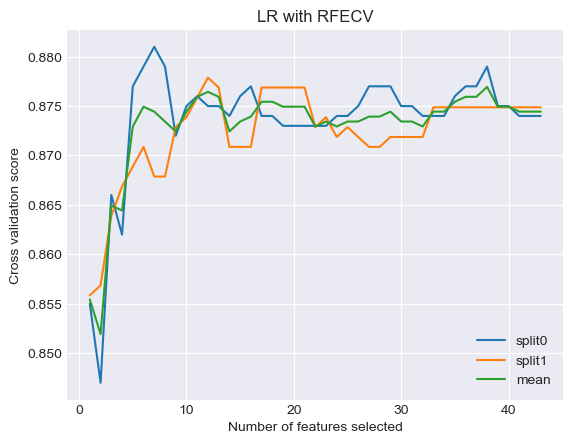

In [6016]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [6017]:
len(rfecv.support_), len(features)

(43, 43)

In [6018]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['Area_Code',
 'Intl_Plan',
 'VMail_Plan',
 'VMail_Message',
 'Day_Mins',
 'Day_Calls',
 'Day_Charge',
 'Eve_Mins',
 'Eve_Calls',
 'Eve_Charge',
 'Night_Mins',
 'Night_Calls',
 'Night_Charge',
 'Intl_Mins',
 'Intl_Calls',
 'Intl_Charge',
 'CustServ_Calls',
 'Loyal',
 'TotalCharges',
 'BigSpender',
 'TotalCustomerCalls',
 'TalkyTalker',
 'TotalTimeOnCustomerCalls',
 'TalkyTalkerButWithMins',
 'ComplainerAndBigSpender',
 'TimeOfCall',
 'FixedIssue',
 'NotLoyalAndComplainer',
 'IntlAndVMail',
 'VMailPlanButLowUsage',
 'AreaAndCustomerCalls',
 'ExpensivePlanAndComplainer',
 'Cranky_Triskaidekaphobias',
 'AverageChargePerCall',
 'ComplainingCustomersWithVMailPlan',
 'InterPlanNoUsage',
 'DailyCallMinAverage',
 'AboveAverageAccLenghtBelowAverageTotalMins']

### Training - After Feature Selection

In [6019]:
display(df.loc[:, features_selected + [target]].head(1))

# normalise
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,features_selected].values)
y_test = df_test.Churn.values

train_models()

,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Loyal,TotalCharges,BigSpender,TotalCustomerCalls,TalkyTalker,TotalTimeOnCustomerCalls,TalkyTalkerButWithMins,ComplainerAndBigSpender,TimeOfCall,FixedIssue,NotLoyalAndComplainer,IntlAndVMail,VMailPlanButLowUsage,AreaAndCustomerCalls,ExpensivePlanAndComplainer,Cranky_Triskaidekaphobias,AverageChargePerCall,ComplainingCustomersWithVMailPlan,InterPlanNoUsage,DailyCallMinAverage,AboveAverageAccLenghtBelowAverageTotalMins,Churn
0,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,True,75.56,True,303,False,717.2,True,False,1,True,False,False,False,4,False,True,0.249373,True,False,2.41,False,0



Model LR
	CV scores: 0.91, 0.90, 0.90, 0.86, 0.85, 0.90, 0.88, 0.83, 0.90, 0.86
	mean=87.89% std=0.0229

Model DT
	CV scores: 0.94, 0.96, 0.95, 0.93, 0.95, 0.95, 0.95, 0.97, 0.94, 0.94
	mean=95.00% std=0.0116

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.88, 0.91, 0.88, 0.89, 0.88, 0.90, 0.86, 0.88, 0.88, 0.88
	mean=88.14% std=0.0116

Model SVC
	CV scores: 0.92, 0.94, 0.91, 0.93, 0.93, 0.91, 0.89, 0.92, 0.93, 0.90
	mean=91.65% std=0.0127

Best Performing Model DT with (mean CV of) accuracy = 95.00%


## Submit

 * Creates zip file to upload of notebooks in project

In [6020]:
import glob
from zipfile import ZipFile

archive = f'{ROOT}/US_Churn_-_Feature_Engineering.zip'

if COLAB:
    files_to_upload = list(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/US_Churn*.ipynb"))
else: 
    files_to_upload = list(glob.glob("US_Churn*.ipynb"))
print(f"Creating zip archive with notbooks {files_to_upload} ...")

with ZipFile(archive,'w') as zip:
    for file in files_to_upload:
        basename = file.split("/Colab Notebooks/")[-1]
        zip.write(file, basename)

Creating zip archive with notbooks ['US_Churn-01-Import.ipynb', 'US_Churn-02-EDA.ipynb', 'US_Churn-03-Baseline_Model.ipynb', 'US_Churn-04-Feature_Engineering.ipynb'] ...
